In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.metrics import accuracy_score, roc_auc_score

In [2]:
from fastai.data.all import *
from fastai.vision.all import *

In [3]:
paths_list = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        paths_list.append(os.path.join(dirname, filename))

In [4]:
def  npy_load(path, pad=1374):
    result = np.zeros((pad,80))
    #print ('load', path)
    try:
        matrix = np.load(path)
        result[:matrix.shape[0],:matrix.shape[1]] = matrix
        #print(result)
        return result 
    except ValueError:
        return result 

In [5]:
%%time
paths_df = pd.DataFrame({'paths':paths_list})
paths_df['set'] = ['train' if x==-1 else 'val' for x in paths_df.paths.str.find('val')]
paths_df['is_noise'] = [1 if x==-1 else 0 for x in paths_df.paths.str.find('clean')]
paths_df['speaker_id'] = paths_df.paths.str.findall(r'\/\d*\/').str[0].str[1:-1]
#paths_df['npy'] = paths_df.paths.apply(npy_load)

CPU times: user 203 ms, sys: 5.78 ms, total: 209 ms
Wall time: 217 ms


In [6]:
def get_files(_, _set = 'train'):
    result = list(paths_df[paths_df['set'] == _set]['paths'].values)
    #print (result)
    return result 

In [7]:
def get_label(path):
    result = paths_df[paths_df['paths'] == path]['is_noise'].values[0]
    #print (result)
    return result

In [8]:
dblock = DataBlock(blocks    = (ImageBlock, CategoryBlock),
                   get_items = get_files,
                   get_x     = npy_load, 
                   get_y     = get_label,
                   splitter  = RandomSplitter()
                  )

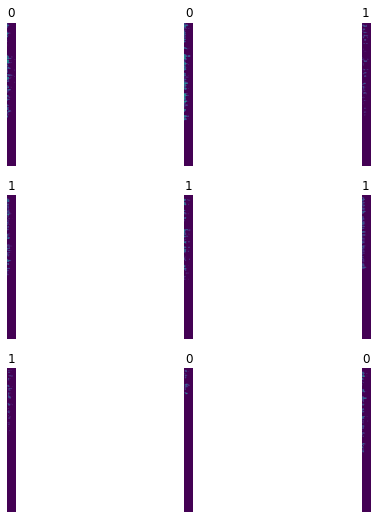

In [9]:
dls = dblock.dataloaders(Path(''))
dls.show_batch()

In [10]:
paths_df.is_noise.value_counts()

1    14001
0    14000
Name: is_noise, dtype: int64

In [11]:
learn = vision_learner(dls, models.resnet18, loss_func=CrossEntropyLossFlat(), metrics=accuracy)
learn.fine_tune(10)
learn.save("model_resnet18")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy,time
0,0.196775,0.173015,0.939167,02:56


epoch,train_loss,valid_loss,accuracy,time
0,0.114820,0.092686,0.971042,02:16
1,0.082543,0.201742,0.936250,02:17
2,0.069557,0.404952,0.876250,02:17
3,0.055220,0.454295,0.801458,02:17
4,0.041661,0.081224,0.979167,02:16
5,0.029983,0.050151,0.982500,02:19
6,0.012046,0.065783,0.982500,02:16
7,0.008896,0.063361,0.983958,02:16
8,0.003886,0.064203,0.985000,02:17
9,0.003334,0.064861,0.985000,02:17


Path('models/model_resnet18.pth')

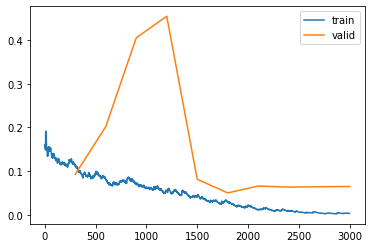

In [12]:
learn.recorder.plot_loss()

In [13]:
%%time
preds = []
for path in paths_df[paths_df['set']=='val'].paths.values:
    with learn.no_bar(), learn.no_logging():
        preds.append(learn.predict(npy_load(path))[0])    

CPU times: user 1min 31s, sys: 984 ms, total: 1min 32s
Wall time: 1min 59s


In [14]:
preds_val = list(map(int,preds))
labels_val = paths_df[paths_df['set']=='val'].is_noise.values

In [15]:
accuracy_score(preds_val,labels_val) 

0.98325

In [16]:
roc_auc_score(preds_val,labels_val) 

0.9832849173352773